##### A quick notebook utilizing pandas to get quick stats out of the genegraph data / scratch

In [1]:
# Library Imports
import glob
import json
import jsonpath_ng
import os 
import pandas as pd
from pyld import jsonld
import plotly.express as px
from ydata_profiling import ProfileReport

# Options
pd.options.display.max_columns = 100

In [106]:
# Constants
INPUT_FOLDER = './input/gene-validity-jsonld-20251030/'
MONDO_MAPPINGS = './input/MONDO_20251030.csv.gz'

In [107]:
# mondo lookup to map ids to names
mondo_mappings = pd.read_csv(MONDO_MAPPINGS, compression='gzip')
mondo_lookup = mondo_mappings.loc[:,['Class ID', 'Preferred Label']]
mondo_lookup['Class ID'] = mondo_lookup['Class ID'].map( lambda x : x.strip('http://purl.obolibrary.org/obo/'))
mondo_lookup.head()

/var/folders/06/r5yblj5x0r30hcgx835svxkm0000gn/T/ipykernel_49165/1278791242.py:2: DtypeWarning:

Columns (14,104) have mixed types. Specify dtype option on import or set low_memory=False.



,Class ID,Preferred Label
0,MONDO_0044647,kyphosis-lateral tongue atrophy-myofibrillar m...
1,MONDO_1010032,"Jacobsen syndrome, non-human animal"
2,MONDO_0007146,"obsolete apnea, central sleep"
3,MONDO_0017964,"obsolete 46,XX disorder of sex development ind..."
4,MONDO_0014635,"microphthalmia, isolated, with coloboma 10"


In [108]:
# Reading a file to check what it has 
genegraph_validity_jsonld_sample = json.load(open(INPUT_FOLDER + '/gg_00140591-caa8-4d47-b4ca-3f0577b16d73v2.1.json'))
genegraph_validity_jsonld_sample['subject']['disease']

'obo:MONDO_0700068'

- Used json_ld for further processing
- Trying to use @embed : always [ assumption it will resolve the labels to proper uris in the files ] 

In [109]:
# Getting a frame to extract all the entities associated with proband data along with the gene and disease
frame = {'@context': genegraph_validity_jsonld_sample['@context'], '@type': 'Proband', '@embed': '@always'}
framed_data = jsonld.frame(genegraph_validity_jsonld_sample, frame)
framed_data["@graph"][0]

{'id': 'https://genegraph.clinicalgenome.org/r/0708860f-3679-4c7c-8809-631729d6490a',
 'type': 'Proband',
 'dc:source': 'https://pubmed.ncbi.nlm.nih.gov/11709191',
 'rdfs:label': 'Yoshida_Patient MK',
 'ageType': 'AgeAtReport',
 'ageUnit': 'Years',
 'ageValue': 8,
 'allele': {'id': 'https://genegraph.clinicalgenome.org/r/9b9f6f3a-715d-4fcf-9271-10d1cd54cb8f',
  'type': 'https://terms.ga4gh.org/VariationDescriptor',
  'http://www.w3.org/2004/02/skos/core#prefLabel': 'NM_017739.3(POMGNT1):c.1649G>A (p.Ser550Asn)',
  'https://terms.ga4gh.org/CanonicalReference': {'id': 'http://reg.genome.network/allele/CA116540'}},
 'detectionMethod': 'The entire coding region (ex 1-22) and intron-exon flanking sequences of POMGNT1 were amplified and directly sequenced.',
 'firstTestingMethod': 'PCR',
 'phenotypeFreeText': 'Clinical features from PMID: 12588800: Moderate white matter lucency. Proband did not show head control at 8yo. CK levels at 4yo = 628 U/L.',
 'phenotypes': ['obo:HP_0007973',
  'obo:H

In [110]:
pd.DataFrame.from_dict([framed_data["@graph"][0]])

,id,type,dc:source,rdfs:label,ageType,ageUnit,ageValue,allele,detectionMethod,firstTestingMethod,phenotypeFreeText,phenotypes,previousTesting,previousTestingDescription,secondTestingMethod,sex,variant
0,https://genegraph.clinicalgenome.org/r/0708860...,Proband,https://pubmed.ncbi.nlm.nih.gov/11709191,Yoshida_Patient MK,AgeAtReport,Years,8,{'id': 'https://genegraph.clinicalgenome.org/r...,The entire coding region (ex 1-22) and intron-...,PCR,Clinical features from PMID: 12588800: Moderat...,"[obo:HP_0007973, obo:HP_0007260, obo:HP_000132...",True,Linkage analysis was performed to narrow down ...,Sanger sequencing,Male,{'id': 'https://genegraph.clinicalgenome.org/r...


In [111]:
# Directory 
genegraph_json_files_path = sorted(glob.glob(f'{INPUT_FOLDER}/*.json'))
len(genegraph_json_files_path)

3371

In [112]:
# Creating a common dataframe with all the probands data

all_proband_data = [] 

for file_path in genegraph_json_files_path:
    try:
        with open(file_path) as jf:
            file_content = json.load(jf)
            gene = file_content['subject']['gene'] 
            disease = file_content['subject']['disease'] 
            framed_data = jsonld.frame(file_content, frame)
            for proband in framed_data.get('@graph',[]):
                temp_proband_df = pd.DataFrame.from_dict([proband])
                temp_proband_df["gene"] = gene
                temp_proband_df["disease"]= disease
                temp_proband_df["source_file"] = os.path.basename(file_path)
                all_proband_data.append(temp_proband_df)
    except Exception as e:
        print(f"An exception {e} occur in reading file at {file_path}")
    

An exception Length of values (2) does not match length of index (1) occur in reading file at ./input/gene-validity-jsonld-20251030/gg_107f9b2d-8bc2-4165-9017-78c78b8151e0v1.0.json
An exception Length of values (2) does not match length of index (1) occur in reading file at ./input/gene-validity-jsonld-20251030/gg_7c114417-af28-41d9-8434-f99db9a16543v1.0.json
An exception 'subject' occur in reading file at ./input/gene-validity-jsonld-20251030/gg_87a36506-8821-4ddc-8ab8-6fa97936ee02.json


In [113]:
proband_data = pd.concat(all_proband_data, ignore_index=True)

In [114]:
proband_data.head()

,id,type,dc:source,rdfs:label,ageType,ageUnit,ageValue,allele,detectionMethod,firstTestingMethod,phenotypeFreeText,phenotypes,previousTesting,previousTestingDescription,secondTestingMethod,sex,variant,gene,disease,source_file,ethnicity,zygosity
0,https://genegraph.clinicalgenome.org/r/0708860...,Proband,https://pubmed.ncbi.nlm.nih.gov/11709191,Yoshida_Patient MK,AgeAtReport,Years,8.0,{'id': 'https://genegraph.clinicalgenome.org/r...,The entire coding region (ex 1-22) and intron-...,PCR,Clinical features from PMID: 12588800: Moderat...,"[obo:HP_0007973, obo:HP_0007260, obo:HP_000132...",True,Linkage analysis was performed to narrow down ...,Sanger sequencing,Male,{'id': 'https://genegraph.clinicalgenome.org/r...,hgnc:19139,obo:MONDO_0700068,gg_00140591-caa8-4d47-b4ca-3f0577b16d73v2.1.json,NaN,NaN
1,https://genegraph.clinicalgenome.org/r/352d557...,Proband,https://pubmed.ncbi.nlm.nih.gov/26908613,Xu_Proband 2,AgeAtReport,Years,32.0,{'id': 'https://genegraph.clinicalgenome.org/r...,Reanalysis of WES data revealed the POMGNT1 va...,Genotyping,Proband suffered from night blindness since ch...,"[obo:HP_0000662, obo:HP_0001133]",True,WES was performed but the cause of RP was unid...,Sanger sequencing,Female,{'id': 'https://genegraph.clinicalgenome.org/r...,hgnc:19139,obo:MONDO_0700068,gg_00140591-caa8-4d47-b4ca-3f0577b16d73v2.1.json,NaN,NaN
2,https://genegraph.clinicalgenome.org/r/5f3835c...,Proband,https://pubmed.ncbi.nlm.nih.gov/11709191,Yoshida_Patient SA,AgeAtReport,Years,7.0,{'id': 'https://genegraph.clinicalgenome.org/r...,The entire coding region (ex 1-22) and intron-...,PCR,Clinical features from PMID: 12588800: Mild wh...,"[obo:HP_0002342, obo:HP_0002365, obo:HP_000207...",True,Linkage analysis was performed to narrow down ...,Sanger sequencing,Female,{'id': 'https://genegraph.clinicalgenome.org/r...,hgnc:19139,obo:MONDO_0700068,gg_00140591-caa8-4d47-b4ca-3f0577b16d73v2.1.json,NaN,NaN
3,https://genegraph.clinicalgenome.org/r/612230d...,Proband,https://pubmed.ncbi.nlm.nih.gov/11709191,Yoshida_Patient YA,AgeAtReport,Years,6.0,{'id': 'https://genegraph.clinicalgenome.org/r...,The entire coding region (ex 1-22) and intron-...,PCR,Clinical features from PMID: 12588800. Moderat...,"[obo:HP_0001320, obo:HP_0001344, obo:HP_000236...",True,Linkage analysis was performed to narrow down ...,Sanger sequencing,Male,{'id': 'https://genegraph.clinicalgenome.org/r...,hgnc:19139,obo:MONDO_0700068,gg_00140591-caa8-4d47-b4ca-3f0577b16d73v2.1.json,NaN,NaN
4,https://genegraph.clinicalgenome.org/r/69b2ace...,Proband,https://pubmed.ncbi.nlm.nih.gov/18195152,Clement_Proband,AgeAtOnset,Years,12.0,{'id': 'https://genegraph.clinicalgenome.org/r...,The POMGNT1 gene was screened for mutations.,Other,Proband developed proximal limb muscle weaknes...,"[obo:HP_0008981, obo:HP_0003323, obo:HP_000054...",True,Abnormal glycosylation of α-DG was noted on mu...,Sanger sequencing,Female,{'id': 'https://genegraph.clinicalgenome.org/r...,hgnc:19139,obo:MONDO_0700068,gg_00140591-caa8-4d47-b4ca-3f0577b16d73v2.1.json,NaN,NaN


In [115]:
proband_data["disease"] = proband_data['disease'].map(lambda x: x.strip('obo:'))
proband_data.head()

,id,type,dc:source,rdfs:label,ageType,ageUnit,ageValue,allele,detectionMethod,firstTestingMethod,phenotypeFreeText,phenotypes,previousTesting,previousTestingDescription,secondTestingMethod,sex,variant,gene,disease,source_file,ethnicity,zygosity
0,https://genegraph.clinicalgenome.org/r/0708860...,Proband,https://pubmed.ncbi.nlm.nih.gov/11709191,Yoshida_Patient MK,AgeAtReport,Years,8.0,{'id': 'https://genegraph.clinicalgenome.org/r...,The entire coding region (ex 1-22) and intron-...,PCR,Clinical features from PMID: 12588800: Moderat...,"[obo:HP_0007973, obo:HP_0007260, obo:HP_000132...",True,Linkage analysis was performed to narrow down ...,Sanger sequencing,Male,{'id': 'https://genegraph.clinicalgenome.org/r...,hgnc:19139,MONDO_0700068,gg_00140591-caa8-4d47-b4ca-3f0577b16d73v2.1.json,NaN,NaN
1,https://genegraph.clinicalgenome.org/r/352d557...,Proband,https://pubmed.ncbi.nlm.nih.gov/26908613,Xu_Proband 2,AgeAtReport,Years,32.0,{'id': 'https://genegraph.clinicalgenome.org/r...,Reanalysis of WES data revealed the POMGNT1 va...,Genotyping,Proband suffered from night blindness since ch...,"[obo:HP_0000662, obo:HP_0001133]",True,WES was performed but the cause of RP was unid...,Sanger sequencing,Female,{'id': 'https://genegraph.clinicalgenome.org/r...,hgnc:19139,MONDO_0700068,gg_00140591-caa8-4d47-b4ca-3f0577b16d73v2.1.json,NaN,NaN
2,https://genegraph.clinicalgenome.org/r/5f3835c...,Proband,https://pubmed.ncbi.nlm.nih.gov/11709191,Yoshida_Patient SA,AgeAtReport,Years,7.0,{'id': 'https://genegraph.clinicalgenome.org/r...,The entire coding region (ex 1-22) and intron-...,PCR,Clinical features from PMID: 12588800: Mild wh...,"[obo:HP_0002342, obo:HP_0002365, obo:HP_000207...",True,Linkage analysis was performed to narrow down ...,Sanger sequencing,Female,{'id': 'https://genegraph.clinicalgenome.org/r...,hgnc:19139,MONDO_0700068,gg_00140591-caa8-4d47-b4ca-3f0577b16d73v2.1.json,NaN,NaN
3,https://genegraph.clinicalgenome.org/r/612230d...,Proband,https://pubmed.ncbi.nlm.nih.gov/11709191,Yoshida_Patient YA,AgeAtReport,Years,6.0,{'id': 'https://genegraph.clinicalgenome.org/r...,The entire coding region (ex 1-22) and intron-...,PCR,Clinical features from PMID: 12588800. Moderat...,"[obo:HP_0001320, obo:HP_0001344, obo:HP_000236...",True,Linkage analysis was performed to narrow down ...,Sanger sequencing,Male,{'id': 'https://genegraph.clinicalgenome.org/r...,hgnc:19139,MONDO_0700068,gg_00140591-caa8-4d47-b4ca-3f0577b16d73v2.1.json,NaN,NaN
4,https://genegraph.clinicalgenome.org/r/69b2ace...,Proband,https://pubmed.ncbi.nlm.nih.gov/18195152,Clement_Proband,AgeAtOnset,Years,12.0,{'id': 'https://genegraph.clinicalgenome.org/r...,The POMGNT1 gene was screened for mutations.,Other,Proband developed proximal limb muscle weaknes...,"[obo:HP_0008981, obo:HP_0003323, obo:HP_000054...",True,Abnormal glycosylation of α-DG was noted on mu...,Sanger sequencing,Female,{'id': 'https://genegraph.clinicalgenome.org/r...,hgnc:19139,MONDO_0700068,gg_00140591-caa8-4d47-b4ca-3f0577b16d73v2.1.json,NaN,NaN


In [116]:
proband_data_w_disease_labels = pd.merge(proband_data,mondo_lookup, left_on='disease', right_on='Class ID', how='left')

In [117]:
proband_data_w_disease_labels.head()

,id,type,dc:source,rdfs:label,ageType,ageUnit,ageValue,allele,detectionMethod,firstTestingMethod,phenotypeFreeText,phenotypes,previousTesting,previousTestingDescription,secondTestingMethod,sex,variant,gene,disease,source_file,ethnicity,zygosity,Class ID,Preferred Label
0,https://genegraph.clinicalgenome.org/r/0708860...,Proband,https://pubmed.ncbi.nlm.nih.gov/11709191,Yoshida_Patient MK,AgeAtReport,Years,8.0,{'id': 'https://genegraph.clinicalgenome.org/r...,The entire coding region (ex 1-22) and intron-...,PCR,Clinical features from PMID: 12588800: Moderat...,"[obo:HP_0007973, obo:HP_0007260, obo:HP_000132...",True,Linkage analysis was performed to narrow down ...,Sanger sequencing,Male,{'id': 'https://genegraph.clinicalgenome.org/r...,hgnc:19139,MONDO_0700068,gg_00140591-caa8-4d47-b4ca-3f0577b16d73v2.1.json,NaN,NaN,MONDO_0700068,myopathy caused by variation in POMGNT1
1,https://genegraph.clinicalgenome.org/r/352d557...,Proband,https://pubmed.ncbi.nlm.nih.gov/26908613,Xu_Proband 2,AgeAtReport,Years,32.0,{'id': 'https://genegraph.clinicalgenome.org/r...,Reanalysis of WES data revealed the POMGNT1 va...,Genotyping,Proband suffered from night blindness since ch...,"[obo:HP_0000662, obo:HP_0001133]",True,WES was performed but the cause of RP was unid...,Sanger sequencing,Female,{'id': 'https://genegraph.clinicalgenome.org/r...,hgnc:19139,MONDO_0700068,gg_00140591-caa8-4d47-b4ca-3f0577b16d73v2.1.json,NaN,NaN,MONDO_0700068,myopathy caused by variation in POMGNT1
2,https://genegraph.clinicalgenome.org/r/5f3835c...,Proband,https://pubmed.ncbi.nlm.nih.gov/11709191,Yoshida_Patient SA,AgeAtReport,Years,7.0,{'id': 'https://genegraph.clinicalgenome.org/r...,The entire coding region (ex 1-22) and intron-...,PCR,Clinical features from PMID: 12588800: Mild wh...,"[obo:HP_0002342, obo:HP_0002365, obo:HP_000207...",True,Linkage analysis was performed to narrow down ...,Sanger sequencing,Female,{'id': 'https://genegraph.clinicalgenome.org/r...,hgnc:19139,MONDO_0700068,gg_00140591-caa8-4d47-b4ca-3f0577b16d73v2.1.json,NaN,NaN,MONDO_0700068,myopathy caused by variation in POMGNT1
3,https://genegraph.clinicalgenome.org/r/612230d...,Proband,https://pubmed.ncbi.nlm.nih.gov/11709191,Yoshida_Patient YA,AgeAtReport,Years,6.0,{'id': 'https://genegraph.clinicalgenome.org/r...,The entire coding region (ex 1-22) and intron-...,PCR,Clinical features from PMID: 12588800. Moderat...,"[obo:HP_0001320, obo:HP_0001344, obo:HP_000236...",True,Linkage analysis was performed to narrow down ...,Sanger sequencing,Male,{'id': 'https://genegraph.clinicalgenome.org/r...,hgnc:19139,MONDO_0700068,gg_00140591-caa8-4d47-b4ca-3f0577b16d73v2.1.json,NaN,NaN,MONDO_0700068,myopathy caused by variation in POMGNT1
4,https://genegraph.clinicalgenome.org/r/69b2ace...,Proband,https://pubmed.ncbi.nlm.nih.gov/18195152,Clement_Proband,AgeAtOnset,Years,12.0,{'id': 'https://genegraph.clinicalgenome.org/r...,The POMGNT1 gene was screened for mutations.,Other,Proband developed proximal limb muscle weaknes...,"[obo:HP_0008981, obo:HP_0003323, obo:HP_000054...",True,Abnormal glycosylation of α-DG was noted on mu...,Sanger sequencing,Female,{'id': 'https://genegraph.clinicalgenome.org/r...,hgnc:19139,MONDO_0700068,gg_00140591-caa8-4d47-b4ca-3f0577b16d73v2.1.json,NaN,NaN,MONDO_0700068,myopathy caused by variation in POMGNT1


In [118]:
# Basic stats
proband_data_w_disease_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20490 entries, 0 to 20489
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          20490 non-null  object 
 1   type                        20490 non-null  object 
 2   dc:source                   20490 non-null  object 
 3   rdfs:label                  20490 non-null  object 
 4   ageType                     15022 non-null  object 
 5   ageUnit                     15020 non-null  object 
 6   ageValue                    12808 non-null  float64
 7   allele                      11769 non-null  object 
 8   detectionMethod             13773 non-null  object 
 9   firstTestingMethod          16570 non-null  object 
 10  phenotypeFreeText           11228 non-null  object 
 11  phenotypes                  14122 non-null  object 
 12  previousTesting             11858 non-null  object 
 13  previousTestingDescription  966

In [119]:
# Check for temporal data
temporal_data = proband_data_w_disease_labels[proband_data_w_disease_labels["ageValue"].notnull()]
temporal_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12808 entries, 0 to 20489
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          12808 non-null  object 
 1   type                        12808 non-null  object 
 2   dc:source                   12808 non-null  object 
 3   rdfs:label                  12808 non-null  object 
 4   ageType                     12743 non-null  object 
 5   ageUnit                     12761 non-null  object 
 6   ageValue                    12808 non-null  float64
 7   allele                      7542 non-null   object 
 8   detectionMethod             9085 non-null   object 
 9   firstTestingMethod          10880 non-null  object 
 10  phenotypeFreeText           7745 non-null   object 
 11  phenotypes                  9888 non-null   object 
 12  previousTesting             7830 non-null   object 
 13  previousTestingDescription  6367 non

In [120]:
proband_data_w_disease_labels.to_pickle("./output/all_proband_data.pkl")

#### EDA

In [2]:
proband_data_w_disease_labels = pd.read_csv("./output/all_proband_data.csv")

In [3]:
profile = ProfileReport(proband_data_w_disease_labels, title="YData Report")

In [4]:
profile.to_file("genegraph_data_2025_10_25.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


%|                                                    | 0/24 [00:00<?, ?it/s]
%|█▊                                          | 1/24 [00:00<00:11,  1.95it/s]
%|███▋                                        | 2/24 [00:00<00:08,  2.56it/s]
%|█████▌                                      | 3/24 [00:01<00:06,  3.17it/s]
%|███████▎                                    | 4/24 [00:01<00:05,  3.35it/s]
%|█████████▏                                  | 5/24 [00:01<00:05,  3.23it/s]
100%|███████████████████████████████████████████| 24/24 [00:02<00:00,  9.77it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
temporal_data = proband_data_w_disease_labels[proband_data_w_disease_labels["ageValue"].notnull()]
temporal_data.shape

(12808, 24)

In [5]:
temporal_data_w_phenotypes = temporal_data[temporal_data["phenotypes"].notnull()]
temporal_data_w_phenotypes.shape

(9888, 24)

In [64]:
temporal_pheno_data_records = temporal_data_w_phenotypes.groupby(by = ["disease","Preferred Label","gene"], as_index=False)["phenotypes"].count().sort_values(by="phenotypes",ascending=False)
temporal_pheno_data_records.rename(columns={"Preferred Label":"Disease Label", "phenotypes": "Number of records with phenotypes"}, inplace=True)
temporal_pheno_data_records.head()

,disease,Disease Label,gene,Number of records with phenotypes
63,MONDO_0005045,hypertrophic cardiomyopathy,hgnc:2472,70
631,MONDO_0012790,amyotrophic lateral sclerosis type 10,hgnc:11571,63
259,MONDO_0009276,Bernard-Soulier syndrome,hgnc:4444,36
1445,MONDO_0100084,alpha-actinopathy,hgnc:129,35
957,MONDO_0015967,monogenic diabetes,hgnc:59,34


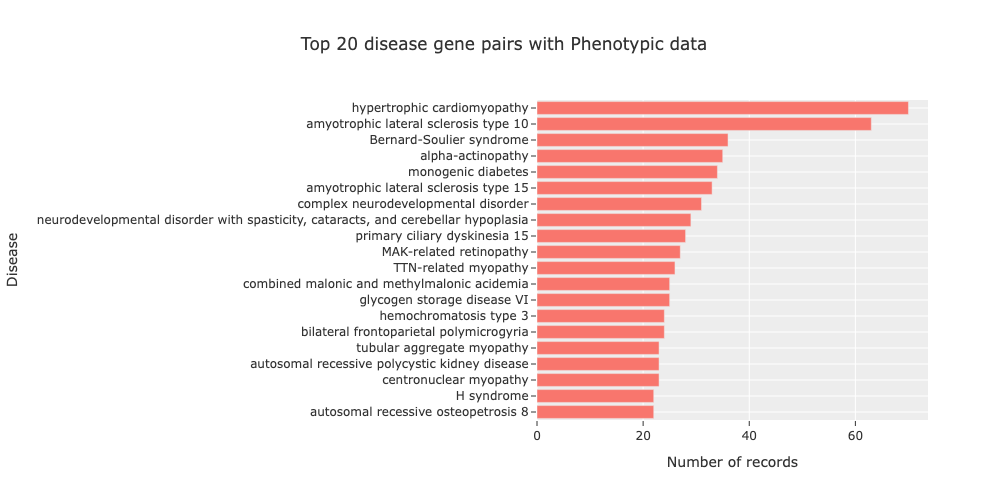

In [46]:
fig = px.bar(temporal_pheno_data_records.iloc[:20].sort_values(by="Number of records with phenotypes"), y = "Disease Label", x= "Number of records with phenotypes",
             title="Top 20 disease gene pairs with Phenotypic data",
             orientation = 'h',
             hover_data=["Disease Label", "gene"],
             template = "ggplot2",
             height = 500
             
            )
fig.layout.yaxis.title = "Disease"
fig.layout.xaxis.title = "Number of records"
fig.show()

In [ ]:
#### Test dataframe 

In [67]:
test_df = temporal_data_w_phenotypes[temporal_data_w_phenotypes["Preferred Label"]== 'Leigh syndrome']
test_df["gene"].unique().shape

(30,)

In [68]:
# For Leigh Syndrome 120 records are segregated across 30 genes , each gene with one record
test_count_df = test_df.groupby(by = ["disease","Preferred Label","gene"], as_index=False)["phenotypes"].count().sort_values(by="phenotypes",ascending=False)
test_count_df

,disease,Preferred Label,gene,phenotypes
25,MONDO_0009723,Leigh syndrome,hgnc:4908,12
16,MONDO_0009723,Leigh syndrome,hgnc:29419,8
3,MONDO_0009723,Leigh syndrome,hgnc:15899,7
24,MONDO_0009723,Leigh syndrome,hgnc:40038,7
21,MONDO_0009723,Leigh syndrome,hgnc:3151,7
14,MONDO_0009723,Leigh syndrome,hgnc:28086,7
9,MONDO_0009723,Leigh syndrome,hgnc:23287,7
29,MONDO_0009723,Leigh syndrome,hgnc:7711,6
12,MONDO_0009723,Leigh syndrome,hgnc:26006,6
1,MONDO_0009723,Leigh syndrome,hgnc:11448,5


In [140]:
# Checking hypertrophic cardiomyopathy with gene = hgnc:2472 
poc_disease = temporal_data_w_phenotypes [ (temporal_data_w_phenotypes["Preferred Label"]=="hypertrophic cardiomyopathy") & (temporal_data_w_phenotypes["gene"]=="hgnc:2472")] 
poc_disease

,id,type,dc:source,rdfs:label,ageType,ageUnit,ageValue,allele,detectionMethod,firstTestingMethod,phenotypeFreeText,phenotypes,previousTesting,previousTestingDescription,secondTestingMethod,sex,variant,gene,disease,source_file,ethnicity,zygosity,Class ID,Preferred Label
663,https://genegraph.clinicalgenome.org/r/01ac566...,Proband,https://pubmed.ncbi.nlm.nih.gov/16352453,Case 6,AgeAtDiagnosis,Years,43.0,NaN,All translated exons analyzed by PCR and dHPLC,PCR,"Angina, dyspnea, (pre)syncope, Max LVWT: 18 mm...",obo:HP_0001639,True,Also carries MYH7 T1377M (Likely pathogenic) v...,NaN,Female,{'id': 'https://genegraph.clinicalgenome.org/r...,hgnc:2472,MONDO_0005045,gg_087b0414-1744-4eb5-86e3-815a9737a04bv1.0.json,NaN,NaN,MONDO_0005045,hypertrophic cardiomyopathy
664,https://genegraph.clinicalgenome.org/r/01dd7b4...,Proband,https://pubmed.ncbi.nlm.nih.gov/16352453,Case 2,AgeAtDiagnosis,Years,16.0,NaN,All translated exons analyzed by PCR and dHPLC,PCR,"Dyspnea, Max LVWT: 25 mm, Resting LVOTO: 0 mmH...",obo:HP_0001639,True,Myofilament-HCM was demonstrated previously fo...,NaN,Male,{'id': 'https://genegraph.clinicalgenome.org/r...,hgnc:2472,MONDO_0005045,gg_087b0414-1744-4eb5-86e3-815a9737a04bv1.0.json,NaN,NaN,MONDO_0005045,hypertrophic cardiomyopathy
667,https://genegraph.clinicalgenome.org/r/1706162...,Proband,https://pubmed.ncbi.nlm.nih.gov/16352453,Case 1,AgeAtDiagnosis,Years,69.0,NaN,All translated exons analyzed by PCR and dHPLC,PCR,"Angina, dyspnea, atrial fibrillation, Max LVWT...",obo:HP_0001639,True,Myofilament-HCM was demonstrated previously fo...,NaN,Female,{'id': 'https://genegraph.clinicalgenome.org/r...,hgnc:2472,MONDO_0005045,gg_087b0414-1744-4eb5-86e3-815a9737a04bv1.0.json,NaN,NaN,MONDO_0005045,hypertrophic cardiomyopathy
670,https://genegraph.clinicalgenome.org/r/1dd1c98...,Proband,https://pubmed.ncbi.nlm.nih.gov/20087448,III.2,AgeAtDiagnosis,Years,30.0,NaN,Mutation analysis of the full coding exons of ...,NaN,Exertional dyspnoea with an NYHA classificatio...,obo:HP_0001639,True,Proband also carries a known pathogenic mutati...,NaN,Male,{'id': 'https://genegraph.clinicalgenome.org/r...,hgnc:2472,MONDO_0005045,gg_087b0414-1744-4eb5-86e3-815a9737a04bv1.0.json,NaN,NaN,MONDO_0005045,hypertrophic cardiomyopathy
671,https://genegraph.clinicalgenome.org/r/1e99c34...,Proband,https://pubmed.ncbi.nlm.nih.gov/22429680,Case 7,AgeAtDiagnosis,Years,25.0,NaN,Analyzed 28 HCM genes by HRM and confirmed mut...,NaN,"Sporadic hypertrophy: diffuse, septal, obstruc...",obo:HP_0001639,True,Proband also carries the c.851+95C>G deep intr...,NaN,Male,{'id': 'https://genegraph.clinicalgenome.org/r...,hgnc:2472,MONDO_0005045,gg_087b0414-1744-4eb5-86e3-815a9737a04bv1.0.json,NaN,NaN,MONDO_0005045,hypertrophic cardiomyopathy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16512,https://genegraph.clinicalgenome.org/r/ee91d09...,Proband,https://pubmed.ncbi.nlm.nih.gov/33035702,II.2 - F10 proband,AgeAtDiagnosis,Years,51.0,{'id': 'https://genegraph.clinicalgenome.org/r...,NGS - 219 genes related to cardiovascular dise...,Next generation sequencing panels,NaN,"['obo:HP_0001639', 'obo:HP_0002094']",NaN,NaN,NaN,Male,{'id': 'https://genegraph.clinicalgenome.org/r...,hgnc:2472,MONDO_0005045,gg_ce44cd4a-01b9-4954-97cd-82e386de79f0v1.0.json,NaN,{'id': 'cg:MonoallelicHeterozygous'},MONDO_0005045,hypertrophic cardiomyopathy
16513,https://genegraph.clinicalgenome.org/r/efd2059...,Proband,https://pubmed.ncbi.nlm.nih.gov/33035702,II.4 - F2 proband,AgeAtDiagnosis,Years,54.0,{'id': 'https://genegraph.clinicalgenome.org/r...,NGS - 219 genes related to cardiovascular dise...,Next generation sequencing panels,NaN,"['obo:HP_0001639', 'obo:HP_0001279']",NaN,NaN,NaN,Male,{'id': 'https://genegraph.clinicalgenome.org/r...,hgnc:2472,MONDO_0005045,gg_ce44cd4a-01b9-4954-97cd-82e386de79f0v1.0.json,NaN,{'id': 'cg:MonoallelicHeterozygous'},MONDO_0005045,hypertrophic cardiomyopathy
16514,https://genegraph.clinicalgenome.org/r/f253

In [141]:
from collections import Counter

Counter(list(poc_disease["phenotypes"]))

Counter({'obo:HP_0001639': 49,
         "['obo:HP_0002094', 'obo:HP_0001639']": 5,
         "['obo:HP_0001639', 'obo:HP_0001279']": 3,
         "['obo:HP_0001279', 'obo:HP_0001712']": 2,
         'obo:HP_0001638': 2,
         "['obo:HP_0001639', 'obo:HP_0002094']": 2,
         "['obo:HP_0001712', 'obo:HP_0001692', 'obo:HP_0005110', 'obo:HP_0001279', 'obo:HP_0004756']": 1,
         "['obo:HP_0003115', 'obo:HP_0001639']": 1,
         "['obo:HP_0001279', 'obo:HP_0001692', 'obo:HP_0001712', 'obo:HP_0004756', 'obo:HP_0005110']": 1,
         "['obo:HP_0001712', 'obo:HP_0100749', 'obo:HP_0001639', 'obo:HP_0002094', 'obo:HP_0001955']": 1,
         "['obo:HP_0001639', 'obo:HP_0011713']": 1,
         "['obo:HP_0001639', 'obo:HP_0012378', 'obo:HP_0100749']": 1,
         "['obo:HP_0100749', 'obo:HP_0001639']": 1})

In [142]:
# Using pickle file to retain the original data structure structure in the data frame

In [2]:
test = pd.read_pickle("./output/all_proband_data.pkl")

In [3]:
poc_disease = test[test["ageValue"].notnull() & test["phenotypes"].notnull()]
poc_disease = poc_disease[(poc_disease["Preferred Label"] == "hypertrophic cardiomyopathy")]

In [4]:
exploding_phenotypes = poc_disease.explode(["phenotypes"])

In [5]:
exploding_phenotypes["phenotypes"].value_counts()

phenotypes
obo:HP_0001639    104
obo:HP_0001712     18
obo:HP_0002094     10
obo:HP_0001279     10
obo:HP_0001644      7
                 ... 
obo:HP_0008689      1
obo:HP_0003700      1
obo:HP_0001645      1
obo:HP_0011715      1
obo:HP_0012378      1
Name: count, Length: 169, dtype: int64

In [6]:
exploding_phenotypes.groupby(by=["ageType","phenotypes"], as_index=False).count().sort_values(by=["phenotypes","ageType"])

,ageType,phenotypes,id,type,dc:source,rdfs:label,ageUnit,ageValue,allele,detectionMethod,firstTestingMethod,phenotypeFreeText,previousTesting,previousTestingDescription,secondTestingMethod,sex,variant,gene,disease,source_file,ethnicity,zygosity,Class ID,Preferred Label
37,AgeAtDiagnosis,obo:HP_0000160,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1
0,AgeAtDeath,obo:HP_0000175,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1
38,AgeAtDiagnosis,obo:HP_0000175,2,2,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2,2,0,0,2,2
156,AgeAtReport,obo:HP_0000175,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,0,1,1
39,AgeAtDiagnosis,obo:HP_0000193,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,AgeAtOnset,obo:HP_0100749,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,0,0,1,1
211,AgeAtReport,obo:HP_0100749,1,1,1,1,1,1,0,0,1,0,1,1,0,1,1,1,1,1,0,0,1,1
212,AgeAtReport,obo:HP_0200021,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,0,1,1
36,AgeAtDeath,obo:HP_0200128,1,1,1,1,1,1,1,0,0,1,1,1,0,1,1,1,1,1,0,0,1,1


# Inference:

- The phenotypic variability looks limited for hypertrophic cardiomyopathy and with three different onset , I don' know  how easy it will be for temporal clustering for the most occuring gene 70 records

- If we look at the disease overall the number of phenotypes increases to 169, but is this good ?
 
- Use pickel format to preserve data formatting